In [3]:
# --- Core ---
import os, copy, math, numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- MONAI ---
from monai.data import Dataset, DataLoader, decollate_batch
from monai.utils import set_determinism
from monai.config import print_config
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, EnsureType,AdjustContrastd,
    Orientationd, Spacingd, ScaleIntensityRanged, ResizeWithPadOrCropd, Resized,
    RandFlipd, RandRotate90d, RandAffined, RandGaussianNoised, RandRotated,
    RandBiasFieldd, RandGibbsNoised, RandAdjustContrastd,CropForegroundd,RandCropByPosNegLabeld,
    Invertd, Activationsd, AsDiscreted
)
from monai.inferers import sliding_window_inference




# --- Torch / model dummy ---
import torch
from monai.networks.nets import UNet   # modelo dummy solo para la demo

In [4]:
import numpy as np

arr = np.array([[1, 2], [3, 4], [5, 6]])
print("Original array:\n", arr)

# Incorrect usage: result is not assigned
np.swapaxes(arr, 0, 1)
print("Array after incorrect swapaxes call:\n", arr.shape) # Will be unchanged

# Correct usage: assign the result
swapped_arr = np.swapaxes(arr, 0, 1)
print("Array after correct swapaxes call:\n", swapped_arr.shape)

Original array:
 [[1 2]
 [3 4]
 [5 6]]
Array after incorrect swapaxes call:
 (3, 2)
Array after correct swapaxes call:
 (2, 3)


In [5]:
def show_triptych(img3d, mask3d=None, pred3d=None, axis="z",ax = None, idx=None, title=None):
    """
    Visualiza un 'slice' de una imagen 3D con máscara GT y predicción superpuestas.
    - img3d: numpy (D,H,W) o (H,W,D) según axis; este helper se encarga.
    - mask3d/pred3d: numpy int con valores {0,1,2} (o {0,1}).
    """
    assert axis in ("z", "y", "x")
    # Reordenar a (D,H,W) para indexar siempre por 'z'
    if img3d.ndim == 3:
        if axis == "z":
            vol = img3d
            msk = mask3d if mask3d is None else mask3d
            prd = pred3d if pred3d is None else pred3d
        elif axis == "y":
            #print("swap y")
            vol = np.swapaxes(img3d, 0, 1)  # (H,D,W)
            #vol = np.swapaxes(vol, 0, 1)    # (D,H,W)
            msk = None if mask3d is None else np.swapaxes(mask3d,0,1)
            prd = None if pred3d is None else np.swapaxes(pred3d,0,1)
        else:  # axis == "x"
            #print("swap x")
            vol = np.swapaxes(img3d, 0, 2)  # (W,H,D)
            #vol = np.swapaxes(vol, 0, 2)    # (D,H,W)
            msk = None if mask3d is None else np.swapaxes(mask3d,0,2)
            prd = None if pred3d is None else np.swapaxes(pred3d,0,2)
    else:
        raise ValueError("img3d debe ser 3D")

    D = vol.shape[0]
    if idx is None:
        # si hay máscara, elegir el slice con mayor área de máscara; sino el central
        if msk is not None:
            areas = [np.count_nonzero(msk[z] > 0) for z in range(D)]
            idx = int(np.argmax(areas))
        else:
            idx = D // 2

    img = vol[idx]
    #fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.imshow(img, cmap="gray")
    if msk is not None:
        # colores: 1->amarillo, 2->cian
        overlay = np.zeros((*msk[idx].shape, 3), dtype=float)
        overlay[msk[idx]==1] = [1.0, 1.0, 0.0]
        overlay[msk[idx]==2] = [0.0, 1.0, 1.0]
        ax.imshow(overlay, alpha=0.35)
    if prd is not None:
        border = (prd[idx]>0).astype(float) - (msk[idx]>0).astype(float) if msk is not None else (prd[idx]>0).astype(float)
        # contorno en rojo para visualizar diferencia
        ax.contour(prd[idx]>0, levels=[0.5], linewidths=1.0, colors="red")
    ax.set_axis_off()
    ax.set_title(title + f"slice {axis}={idx}")
    #plt.show()
    return idx


In [6]:
SPACING = (1.0, 1.0, 1.0)
SPATIAL_SIZE = (120, 120, 120)
set_determinism(seed=42)  # hazlo False/None si quieres aleatoriedad total

def get_train_transforms(augment=True):
    t = [
        LoadImaged(keys=["image","label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Spacingd(keys=["image","label"], pixdim=SPACING, mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=15.0, b_min=0.0, b_max=1.0, clip=True),
        AdjustContrastd(keys=["image"], gamma=(0.8)),  # Ajuste de contraste
        Resized(keys=["image","label"], spatial_size=SPATIAL_SIZE),
    ]
    if augment:
        t += [
            # evita flips L/R por lateralidad (asumiendo RAS: eje X ~ L/R)
            RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=1),  # A/P
            RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=2),  # S/I
            RandRotate90d(keys=["image","label"], prob=0.5, max_k=3),
            RandRotated(
                keys=["image","label"], prob=0.5,
                range_x=(-0.4, 0.4),
                mode=("bilinear","nearest")),
            RandAffined(
                keys=["image","label"], prob=0.5,
                rotate_range=(0.4,0,0),
                translate_range=(0, 20 , 20),
                scale_range=(0.10,0.10,0.10),
                padding_mode="zeros",
                mode=("bilinear","nearest"),
            ),
            RandBiasFieldd(keys=["image"], prob=0.5, coeff_range=(0.0,0.05)),
            RandGaussianNoised(keys=["image"], prob=0.5, std=0.01),
            RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7,1.5)),
        ]
    t += [EnsureTyped(keys=["image","label"], track_meta=True)]  # MetaTensor (requerido para Invertd)
    return Compose(t)

def get_val_transforms():
    return Compose([
        LoadImaged(keys=["image","label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Spacingd(keys=["image","label"], pixdim=SPACING, mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=15.0, b_min=0.0, b_max=1.0, clip=True),
        AdjustContrastd(keys=["image"], gamma=(0.8)),  # Ajuste de contraste
        Resized(keys=["image","label"], spatial_size=SPATIAL_SIZE),
        EnsureTyped(keys=["image","label"], track_meta=True),
    ])

def get_test_transforms():
    return Compose([
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
        Spacingd(keys=["image"], pixdim=SPACING, mode="bilinear"),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=15.0, b_min=0.0, b_max=1.0, clip=True),
        AdjustContrastd(keys=["image"], gamma=(0.8)),  # Ajuste de contraste
        Resized(keys=["image"], spatial_size=SPATIAL_SIZE),
        EnsureTyped(keys=["image"], track_meta=True),
    ])


In [7]:
df = pd.read_csv("../results/preprocessed_data/task2/df_train_hipp.csv")
df.head(2)

,filepath_label,filename_label,ID,source_label,filepath
0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001_HF_hipp.nii.gz,LISA_0001,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...
1,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0005_HF_hipp.nii.gz,LISA_0005,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...


In [ ]:
from torch.utils.data import Dataset
import os
from typing import List, Iterable, Optional
import tqdm

from __future__ import annotations

from torch.utils.data import Dataset
from typing import Optional, Dict, Any
import pandas as pd
import numpy as np
import torch
import os

try:
    import nibabel as nib  # solo usado si transform es None
except ImportError:
    nib = None


class MRIDataset3D(Dataset):
    """
    Minimal 3D MRI dataset that plays nicely with MONAI dict transforms.

    - Expects a DataFrame with column 'filepath' and, if training, 'filepath_label'.
    - If `transform` is provided, it should accept/return a dict with keys
      'image' and (optionally) 'label' (e.g., MONAI's Compose with LoadImaged, etc).
    - If `transform` is None, falls back to nibabel loading and returns torch tensors.

    Returns (by default) a dict with:
        {'image': Tensor [1,D,H,W], 'label': Tensor [1,D,H,W] (if available),
         'image_path': str, 'label_path': Optional[str]}
    """

    def __init__(
        self,
        df: pd.DataFrame,
        is_train: bool = True,
        transform: Optional[callable] = None,
    ) -> None:
        self.df = df.reset_index(drop=True)
        self.is_train = is_train
        self.transform = transform

        self._has_label = self.is_train and ("filepath_label" in self.df.columns)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        row = self.df.iloc[idx]
        #print("row:",row )
        img_path = row["filepath"]
        sample: Dict[str, Any] = {"image": img_path, "image_path": img_path}

        if self._has_label and pd.notna(row.get("filepath_label", None)):
            lab_path = row["filepath_label"]
            sample["label"] = lab_path
            sample["label_path"] = lab_path
        else:
            sample["label_path"] = ""

        #print("sample:",sample )
        if self.transform is not None:
            # MONAI-style: transform loads and returns tensors/MetaTensors
            out = self.transform(sample)
            # ensure the meta paths stay available
            out.setdefault("image_path", img_path)
            out.setdefault("label_path", sample.get("label_path", ""))
            return out

        # Fallback path: no transform -> direct nibabel load
        img_t = self._fallback_load(img_path)
        out = {"image": img_t, "image_path": img_path}

        if sample["label_path"] is not None:
            lab_t = self._fallback_load_label(sample["label_path"])
            out["label"] = lab_t
            out["label_path"] = sample["label_path"]

        return out


In [9]:
def df_to_list(df, is_test=False):
    data = []
    for _, r in df.iterrows():
        item = {"image": r["filepath"]}
        if not is_test and "filepath_label" in df.columns and pd.notna(r.get("filepath_label", None)):
            item["label"] = r["filepath_label"]
        data.append(item)
    return data

# Ejemplo:
# df = pd.read_csv("df_train.csv")
#train_data = df_to_list(df, is_test=False)
#train_ds = Dataset(train_data, transform=get_train_transforms(augment=True))
#val_ds   = Dataset(train_data, transform=get_val_transforms())  # para demo uso el mismo df

train_ds = MRIDataset3D(df, is_train=True,  transform=get_train_transforms(augment=True))
val_ds   = MRIDataset3D(df, is_train=True,  transform=get_val_transforms())
train_loader = DataLoader(train_ds, batch_size=10, shuffle=False, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=10, shuffle=False, num_workers=2, pin_memory=True)

row: filepath_label    /data/cristian/projects/med_data/rise-miccai/t...
filename_label                             LISA_0001_HF_hipp.nii.gz
ID                                                        LISA_0001
source_label                                                HF_hipp
filepath          /data/cristian/projects/med_data/rise-miccai/t...
Name: 0, dtype: object
sample: {'image': '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz', 'image_path': '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz', 'label': '/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz', 'label_path': '/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz'}
row: filepath_label    /data/cristian/projects/med_data/rise-miccai/t...
filename_label                             LISA_0011_HF_hipp.nii.gz
ID                                                        LISA_001

row: filepath_label    /data/cristian/projects/med_data/rise-miccai/t...
filename_label                             LISA_0012_HF_hipp.nii.gz
ID                                                        LISA_0012
source_label                                                HF_hipp
filepath          /data/cristian/projects/med_data/rise-miccai/t...
Name: 11, dtype: object
sample: {'image': '/data/cristian/projects/med_data/rise-miccai/task-2/740/155885740/LISA_0012_ciso.nii.gz', 'image_path': '/data/cristian/projects/med_data/rise-miccai/task-2/740/155885740/LISA_0012_ciso.nii.gz', 'label': '/data/cristian/projects/med_data/rise-miccai/task-2/965/155887965/LISA_0012_HF_hipp.nii.gz', 'label_path': '/data/cristian/projects/med_data/rise-miccai/task-2/965/155887965/LISA_0012_HF_hipp.nii.gz'}
row: filepath_label    /data/cristian/projects/med_data/rise-miccai/t...
filename_label                             LISA_0005_HF_hipp.nii.gz
ID                                                        LISA_00

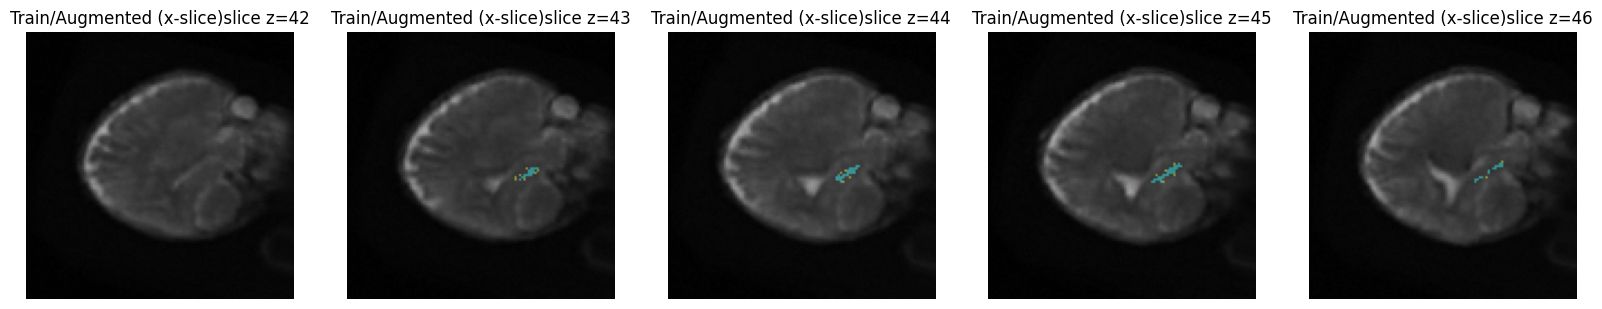

Val sample 0: /data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz


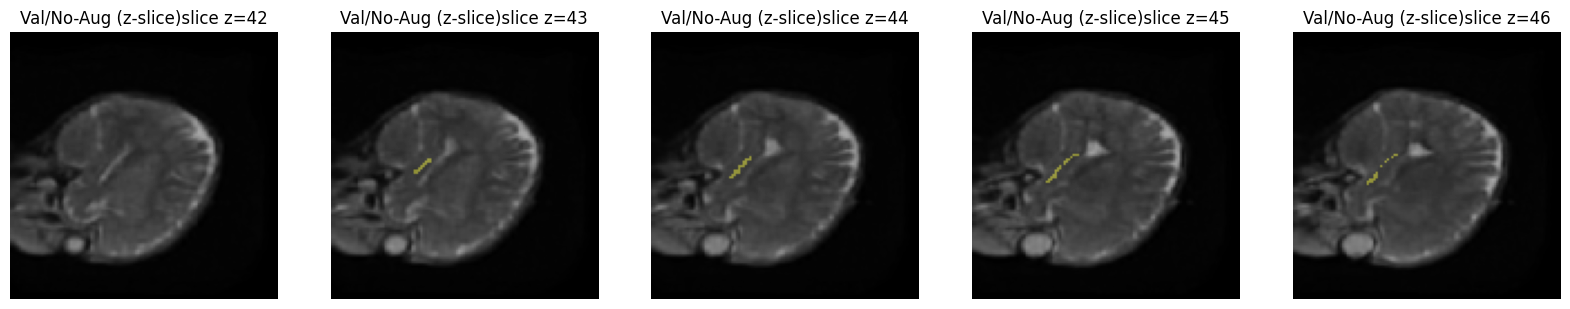

Train sample 1: /data/cristian/projects/med_data/rise-miccai/task-2/704/155885704/LISA_0005_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/963/155887963/LISA_0005_HF_hipp.nii.gz


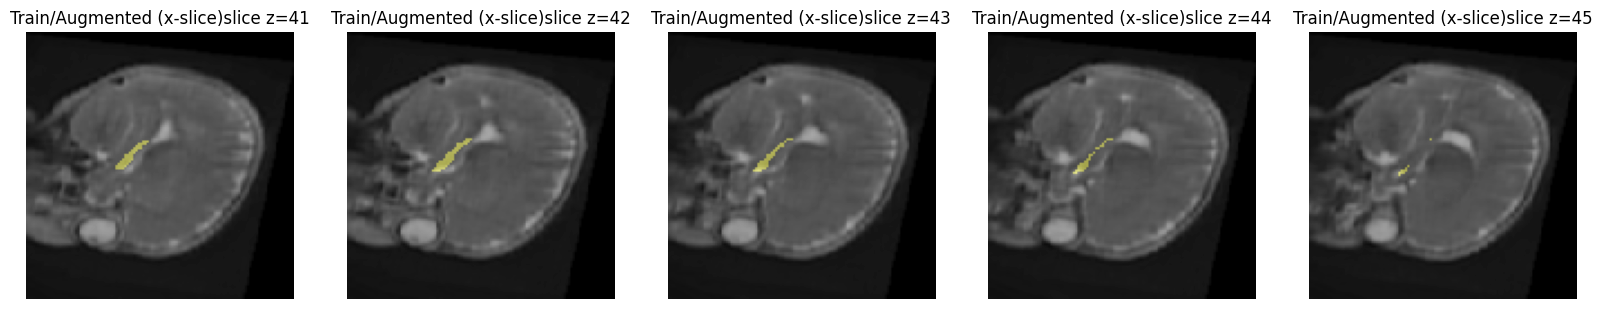

Val sample 1: /data/cristian/projects/med_data/rise-miccai/task-2/704/155885704/LISA_0005_ciso.nii.gz, /data/cristian/projects/med_data/rise-miccai/task-2/963/155887963/LISA_0005_HF_hipp.nii.gz


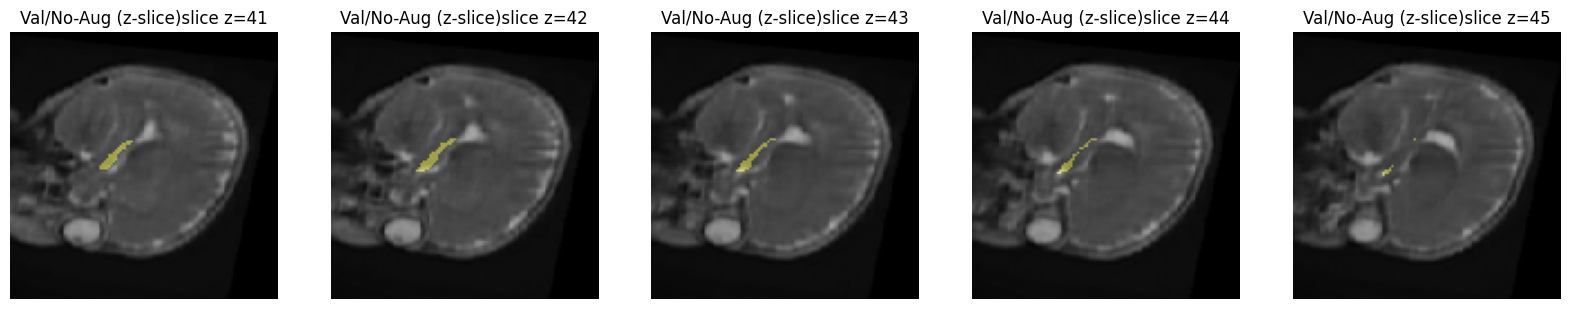

In [10]:
# Visualizar un batch "tal cual" pasa por las transforms
batch = next(iter(train_loader))
batch_val = next(iter(val_loader))
for i in range(2):

  img = batch["image"][i].as_tensor().cpu().numpy()[0]     # (D,H,W)
  lab = batch["label"][i].as_tensor().cpu().numpy()[0]     # (D,H,W)
  img_v = batch_val["image"][i].as_tensor().cpu().numpy()[0]
  lab_v = batch_val["label"][i].as_tensor().cpu().numpy()[0]

  image_path = batch["image_path"][i]
  label_path = batch["label_path"][i]
  print(f"Train sample {i}: {image_path}, {label_path}")
  fig, axes = plt.subplots(1, 5, figsize=(20, 10))
  axes = axes.ravel()
  idx = show_triptych(img_v, mask3d=lab_v, axis="z", title=f"Val/No-Aug (z-slice)", ax=axes[0])
  #idx = show_triptych(img, mask3d=lab, axis="z", title=f"Train/Augmented (x-slice)", ax=axes[0])
  for cnt,idx_ in enumerate(range(idx-2,idx+3)):
    show_triptych(img, mask3d=lab, axis="z", title=f"Train/Augmented (x-slice)", idx=idx_, ax=axes[cnt])
  plt.show()
  image_path = batch_val["image_path"][i]
  label_path = batch_val["label_path"][i]
  print(f"Val sample {i}: {image_path}, {label_path}")
  fig, axes = plt.subplots(1, 5, figsize=(20, 10))
  axes = axes.ravel()
  for cnt,idx_ in enumerate(range(idx-2,idx+3)):
    show_triptych(img_v, mask3d=lab_v, axis="z", title=f"Val/No-Aug (z-slice)",idx=idx_, ax=axes[cnt])
  plt.show()


In [11]:
batch_val["image_path"]

['/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/704/155885704/LISA_0005_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/709/155885709/LISA_0002_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/738/155885738/LISA_0010_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/734/155885734/LISA_0003_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/736/155885736/LISA_0006_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/714/155885714/LISA_0004_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/717/155885717/LISA_0007_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/720/155885720/LISA_0008_ciso.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/737/155885737/LISA_0009_ciso.nii.gz']

In [12]:
img.ndim, img.shape

(3, (120, 120, 120))

In [13]:
img.min(),img.max()

(0.0, 0.66082096)

In [14]:
df.head()

,filepath_label,filename_label,ID,source_label,filepath
0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001_HF_hipp.nii.gz,LISA_0001,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...
1,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0005_HF_hipp.nii.gz,LISA_0005,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...
2,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0002_HF_hipp.nii.gz,LISA_0002,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...
3,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0010_HF_hipp.nii.gz,LISA_0010,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...
4,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0003_HF_hipp.nii.gz,LISA_0003,HF_hipp,/data/cristian/projects/med_data/rise-miccai/t...


In [15]:
df["filepath_label"][0],df["filepath"][0]

('/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz',
 '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz')

row: filepath          /data/cristian/projects/med_data/rise-miccai/t...
filepath_label    /data/cristian/projects/med_data/rise-miccai/t...
Name: 0, dtype: object
sample: {'image': '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz', 'image_path': '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz', 'label': '/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz', 'label_path': '/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz'}
row: filepath          /data/cristian/projects/med_data/rise-miccai/t...
filepath_label    /data/cristian/projects/med_data/rise-miccai/t...
Name: 0, dtype: object
sample: {'image': '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz', 'image_path': '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz', 'label': '/data/cristian/projects

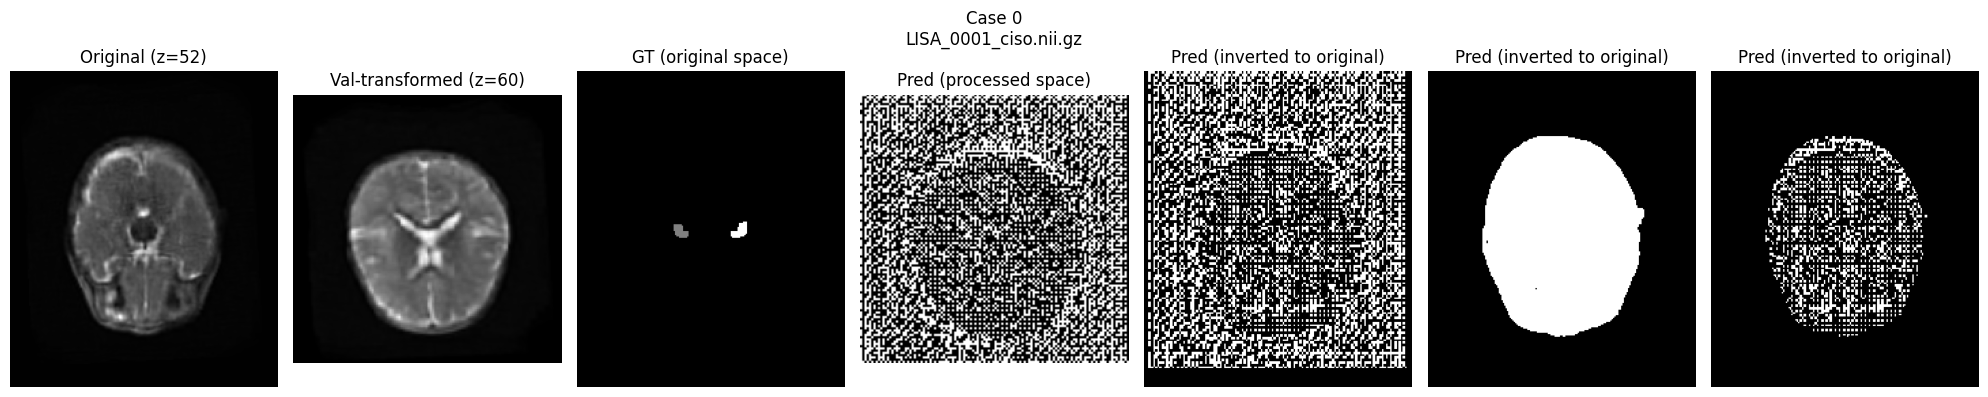

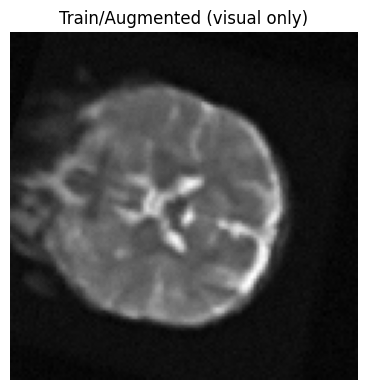

In [39]:
# monai==1.3+ / pytorch >= 1.12
import os, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRanged, EnsureTyped, Invertd, Activationsd, AsDiscreted
)
from monai.data import decollate_batch
from monai.utils import set_determinism

# ------------------------------------------------------------
# 0) Reproducibilidad
# ------------------------------------------------------------
# ----------------------------------------------------------
# 1) Tu DataFrame con columnas: filepath (imagen), filepath_label (segmentación)
#    Ejemplo mínimo (reemplaza con tu df real)
# ------------------------------------------------------------

# =========================
# Sliding-window + Invertd
# =========================
import os, copy
import numpy as np
import nibabel as nib
import torch
import matplotlib.pyplot as plt

from monai.data import DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, Invertd, Activationsd, AsDiscreted, EnsureType
from monai.networks.nets import UNet
from monai.utils import set_determinism

set_determinism(seed=2025)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------- helpers ----------
def load_nifti(path):
    nii = nib.load(path)
    arr = nii.get_fdata()
    # asegura float32
    return np.asarray(arr, dtype=np.float32)

def choose_slice_z(label3d=None, img3d=None):
    """
    Elige slice axial:
    - si hay label -> mayor área de máscara
    - si no -> central
    Espera volúmenes (D,H,W). Si vienen (1,D,H,W) quita canal.
    """
    if label3d is not None:
        if label3d.ndim == 4: label3d = label3d[0]
        D = label3d.shape[0]
        if np.max(label3d) > 0:
            areas = [np.count_nonzero(label3d[z] > 0) for z in range(D)]
            return int(np.argmax(areas))
    # fallback
    if img3d is not None and img3d.ndim >= 3:
        D = img3d.shape[-3]
        return D // 2
    return 0

def show_grid7(
    img_orig, img_val, lbl_orig, pred_proc, pred_inv,img_orig_masked, pred_inv_masked,
    z_idx=None, suptitle=""
):
    """
    Dibuja 5 columnas (todas como (D,H,W)):
    1) imagen original
    2) imagen con val_transforms
    3) label original
    4) pred (espacio procesado, val_transforms)
    5) pred invertida (espacio original)
    """
    # normaliza dimensiones (quita canal si existe)
    def norm3d(x):
        if x is None: return None
        x = np.asarray(x)
        if x.ndim == 4: x = x[0]
        #print(x.shape)
        x = np.swapaxes(x, 0, 2)  # (W,H,D)
        return x

    img_orig = norm3d(img_orig)
    img_val  = norm3d(img_val)
    lbl_orig = norm3d(lbl_orig)
    pred_proc= norm3d(pred_proc)
    pred_inv = norm3d(pred_inv)
    pred_inv_masked = norm3d(pred_inv_masked)
    img_orig_masked = norm3d(img_orig_masked)

    if z_idx is None:
        z_idx = choose_slice_z(lbl_orig, img_orig)

    fig, axs = plt.subplots(1, 7, figsize=(20, 4))
    for ax in axs: ax.axis("off")

    # 1) original
    axs[0].imshow(img_orig[z_idx], cmap="gray")
    axs[0].set_title(f"Original (z={z_idx})")

    # 2) val-transformed
    z2 = img_val.shape[0] // 2 if img_val is not None else 0
    axs[1].imshow(img_val[z2], cmap="gray")
    axs[1].set_title(f"Val-transformed (z={z2})")

    # 3) label original
    if lbl_orig is not None:
        axs[2].imshow(lbl_orig[z_idx], cmap="gray")
        axs[2].set_title("GT (original space)")
    else:
        axs[2].set_title("GT (none)")

    # 4) pred en espacio procesado
    if pred_proc is not None:
        z3 = pred_proc.shape[0] // 2
        axs[3].imshow(pred_proc[z3], cmap="gray")
        axs[3].set_title("Pred (processed space)")
    else:
        axs[3].set_title("Pred (processed)")

    # 5) pred invertida a espacio original
    if pred_inv is not None:
        axs[4].imshow(pred_inv[z_idx], cmap="gray")
        axs[4].set_title("Pred (inverted to original)")
    else:
        axs[4].set_title("Pred (inverted)")


    # 5) pred invertida a espacio original
    if pred_inv_masked is not None:
        axs[5].imshow(img_orig_masked[z_idx], cmap="gray")
        axs[5].set_title("Pred (inverted to original)")
    else:
        axs[5].set_title("Pred (inverted)")

    # 5) pred invertida a espacio original
    if pred_inv_masked is not None:
        axs[6].imshow(pred_inv_masked[z_idx], cmap="gray")
        axs[6].set_title("Pred (inverted to original)")
    else:
        axs[6].set_title("Pred (inverted)")


    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

# ---------- datasets ----------
# df_train: tu DataFrame ya cargado con columnas ['filepath', 'filepath_label']
data = [{
    "filepath": "/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz",
    "filepath_label": "/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz"
}]
df = pd.DataFrame(data)
df_train = df.copy()

val_tfm   = get_val_transforms()
train_tfm = get_train_transforms(augment=True)

ds_val   = MRIDataset3D(df_train, is_train=True, transform=val_tfm)
ds_train = MRIDataset3D(df_train, is_train=True, transform=train_tfm)

val_loader = DataLoader(ds_val, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# ---------- modelo dummy ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,       # binario
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
).to(device).eval()

# ---------- post-procesado ----------
post_pred = Compose([
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

# ---------- inferencia con sliding window + Invertd ----------
roi_size      = SPATIAL_SIZE          # p.ej. (120,120,120)
sw_batch_size = 1
overlap       = 0.25

with torch.no_grad():
    for idx_case, batch in enumerate(val_loader):
        # paths para cargar "original"
        img_path = batch["image_path"][0]
        lbl_path = batch.get("label_path", [""])[0]

        # --- ORIGINAL (sin transforms) ---
        img_orig = load_nifti(img_path)
        lbl_orig = load_nifti(lbl_path) if (lbl_path and os.path.exists(lbl_path)) else None

        # --- PROCESADO (val_transforms) ---
        img_val = batch["image"].as_tensor().cpu().numpy()  # (B=1, C=1, D,H,W)
        if "label" in batch:
            lbl_val = batch["label"].as_tensor().cpu().numpy()
        else:
            lbl_val = None

        # --- sliding-window inference ---
        image = batch["image"].to(device)
        logits = sliding_window_inference(
            inputs=image,
            roi_size=roi_size,
            sw_batch_size=sw_batch_size,
            predictor=model,
            overlap=overlap,
            mode="gaussian",
        )
        batch["pred"] = logits.cpu()  # (1,1,D,H,W)

        # decouple per-item dict for Invertd
        elems = decollate_batch(batch)
        preds_inv = []
        preds_proc = []

        for elem in elems:
            # guarda copia de meta de image para asociarla a 'pred'
            elem["pred_meta_dict"] = copy.deepcopy(elem["image"].meta)

            # activa + umbral (espacio procesado)
            elem = post_pred(elem)  # añade 'pred' binaria en procesado

            # guarda pred procesada (para ploteo)
            preds_proc.append(elem["pred"].cpu().numpy())

            # Invertd: regresa 'pred' al espacio/tamaño original del archivo
            inv = Invertd(
                keys="pred",
                transform=val_tfm,
                orig_keys="image",
                meta_keys="pred_meta_dict",
                orig_meta_keys="image_meta_dict",
                nearest_interp=True,  # máscaras -> interpolación por vecino
                to_tensor=True,
            )
            elem = inv(elem)

            # tensor invertido -> numpy
            pred_inv_np = elem["pred"].cpu().numpy()
            preds_inv.append(pred_inv_np)

        # --- también muestra cómo luce el MISMO caso con augmentación (train_tfm) ---
        # (solo para visual: no es el que se usó para inferencia)
        # buscamos el mismo índice en ds_train (asumen mismo orden)
        sample_train_aug = ds_train[idx_case]
        img_train_aug = sample_train_aug["image"].as_tensor().cpu().numpy()

        # --- plotting de 5 columnas ---
        show_grid7(
            img_orig=img_orig,                  # 1) original
            img_val=img_val[0, 0],              # 2) val-transformed (quita B,C)
            lbl_orig=lbl_orig,                  # 3) GT original
            pred_proc=preds_proc[0][0],         # 4) pred (processed), quita B,C
            pred_inv=preds_inv[0][0],           # 5) pred invertida (original space)
            img_orig_masked = (img_orig>0.5)*1,  # 1) original masked
            pred_inv_masked=(img_orig>0.5)*preds_inv[0][0],           # 5) pred invertida (original space)            
            suptitle=f"Case {idx_case}\n{os.path.basename(img_path)}"
        )

        # adicional: muestra cómo quedó la imagen con augmentación (train)
        # (mismo caso, solo referencia visual)
        z_aug = img_train_aug.shape[-3] // 2
        plt.figure(figsize=(4,4))
        plt.imshow(img_train_aug[0, z_aug], cmap="gray")
        plt.title("Train/Augmented (visual only)")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        # si solo quieres el primer caso, rompe aquí
        break


In [22]:
img_orig.shape

(197, 233, 189)

reading checkpoint: ./fold_models/fold_2/best_model.pth
row: filepath          /data/cristian/projects/med_data/rise-miccai/t...
filepath_label    /data/cristian/projects/med_data/rise-miccai/t...
Name: 0, dtype: object
sample: {'image': '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz', 'image_path': '/data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz', 'label': '/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz', 'label_path': '/data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz'}

=== Case 0 ===
image_path: /data/cristian/projects/med_data/rise-miccai/task-2/735/155885735/LISA_0001_ciso.nii.gz
label_path: /data/cristian/projects/med_data/rise-miccai/task-2/960/155887960/LISA_0001_HF_hipp.nii.gz
Original image shape: (197, 233, 189)
Original label shape: (197, 233, 189)
Processed image tensor: (1, 1, 96, 96, 96)
Processed label t

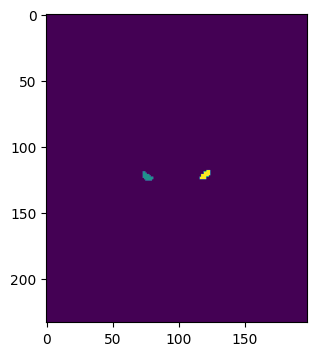

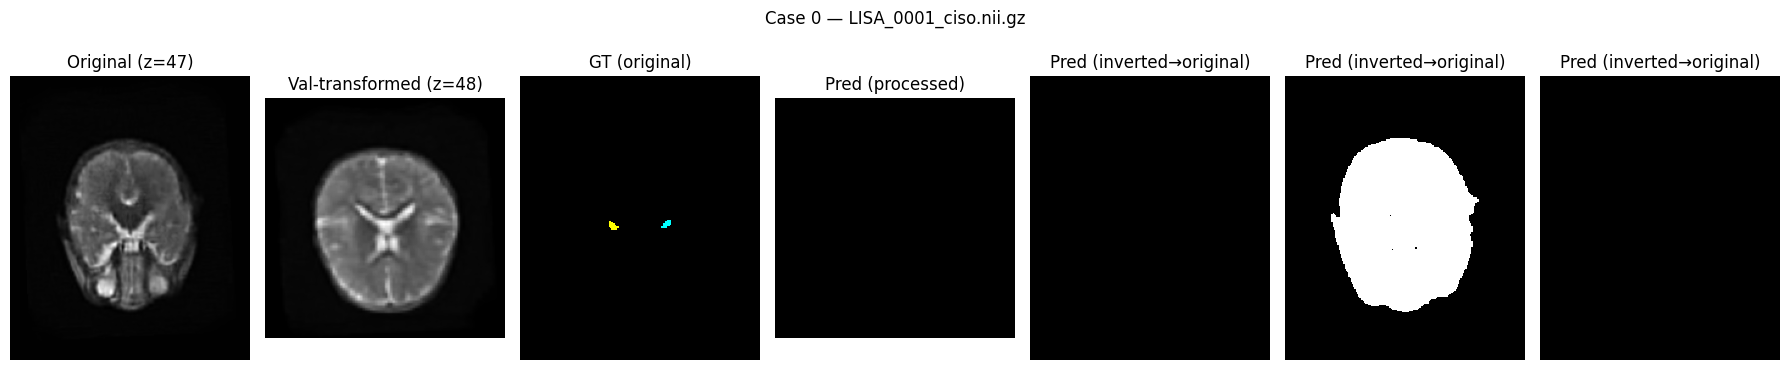

lbl_orig: 2 0 (189, 233, 197)


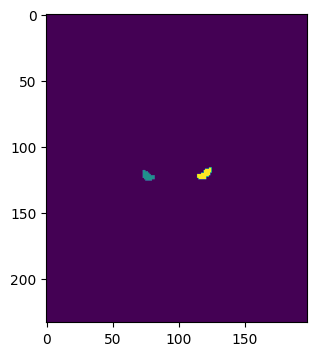

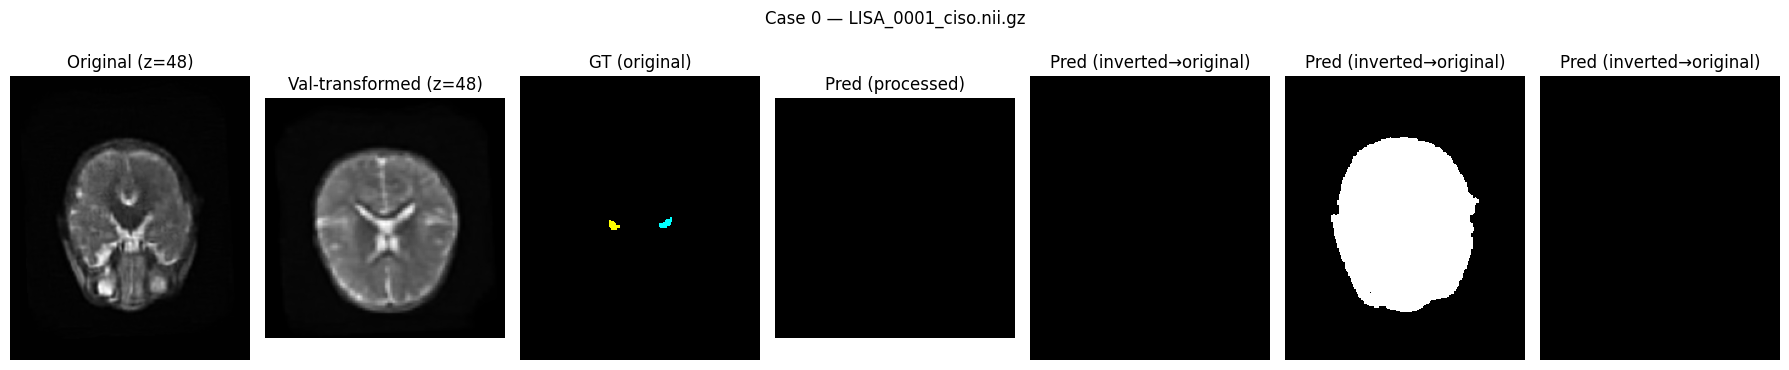

lbl_orig: 2 0 (189, 233, 197)


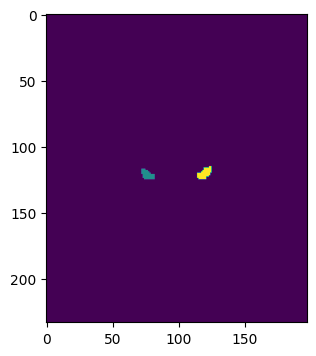

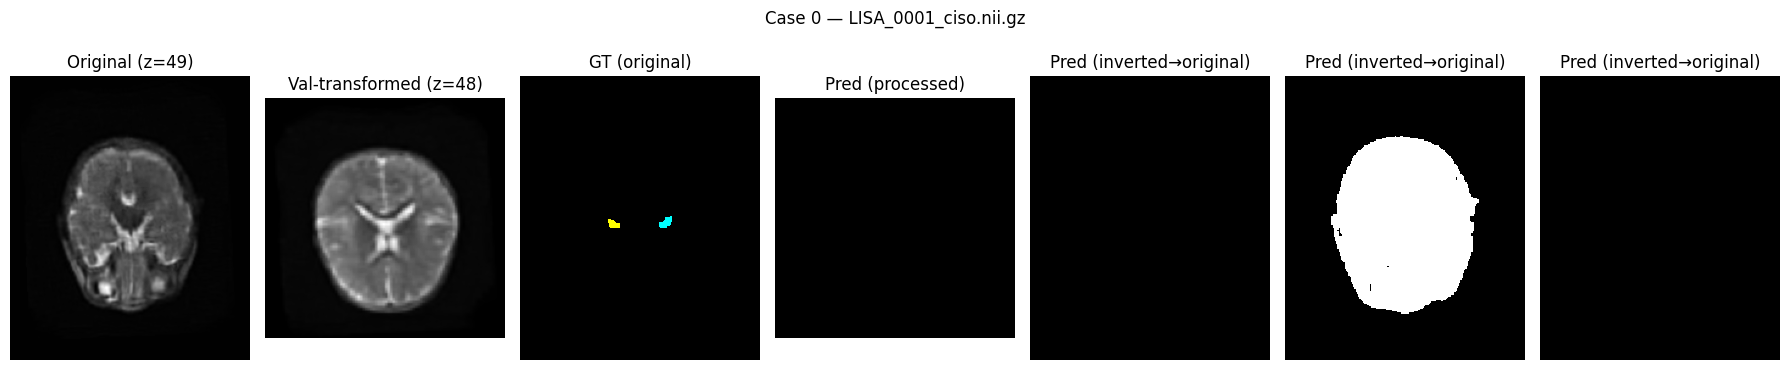

lbl_orig: 2 0 (189, 233, 197)


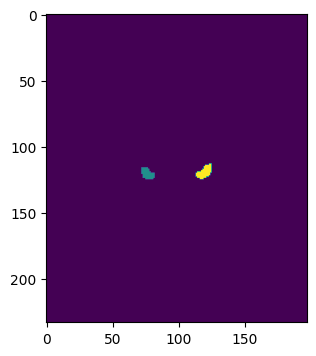

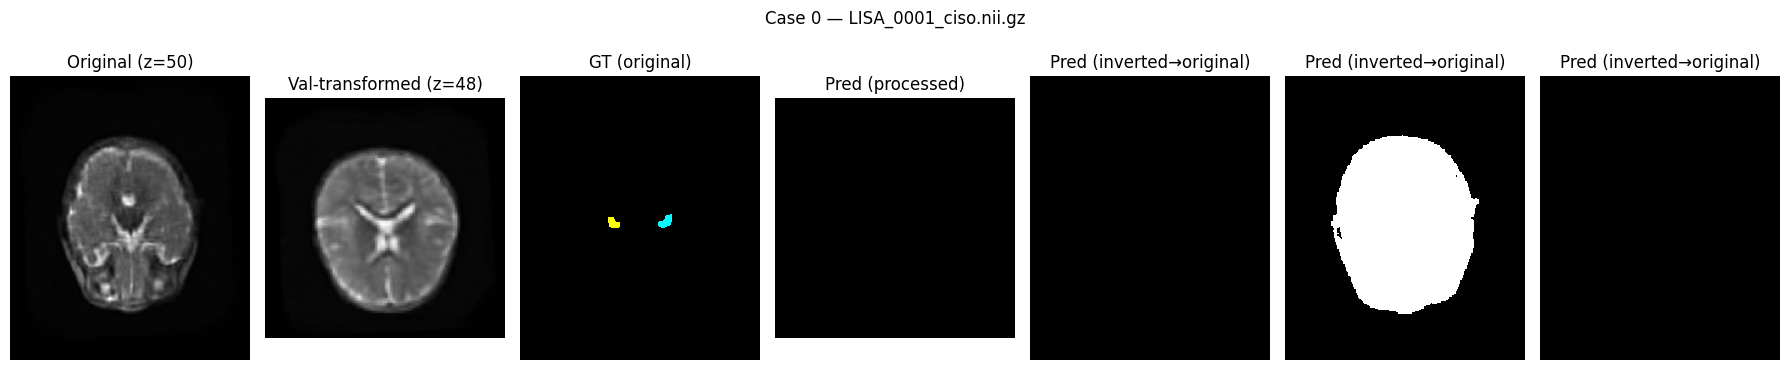

lbl_orig: 2 0 (189, 233, 197)


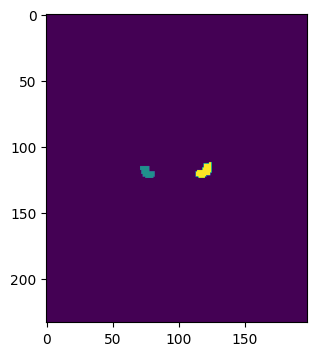

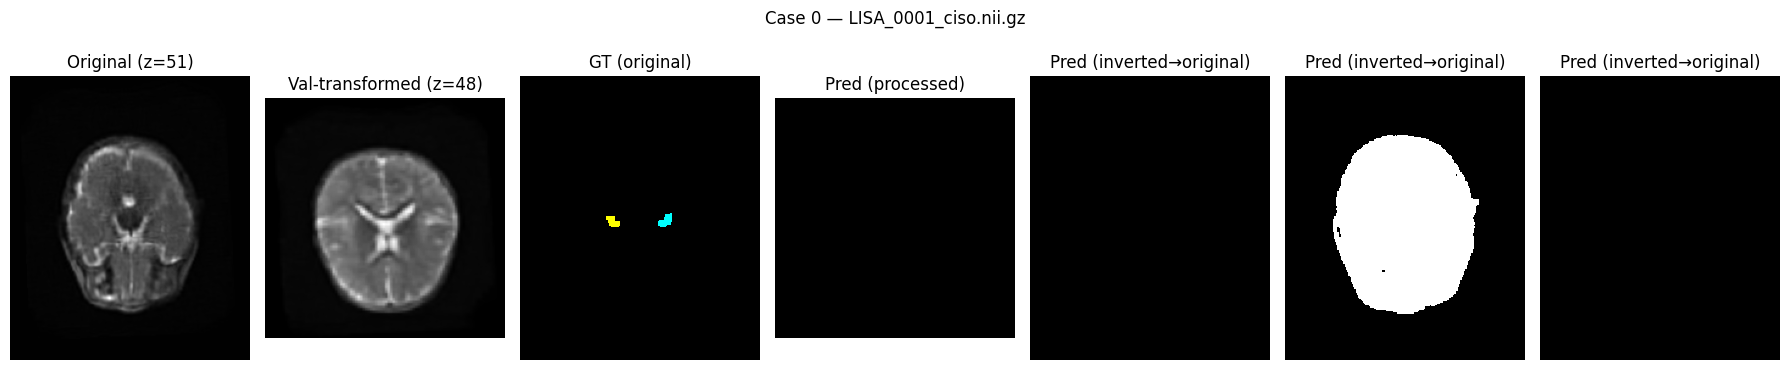

lbl_orig: 2 0 (189, 233, 197)


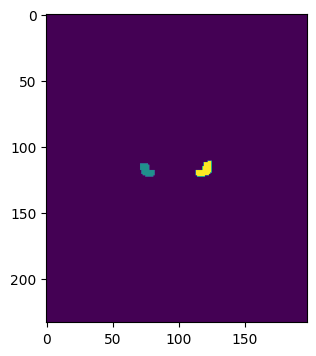

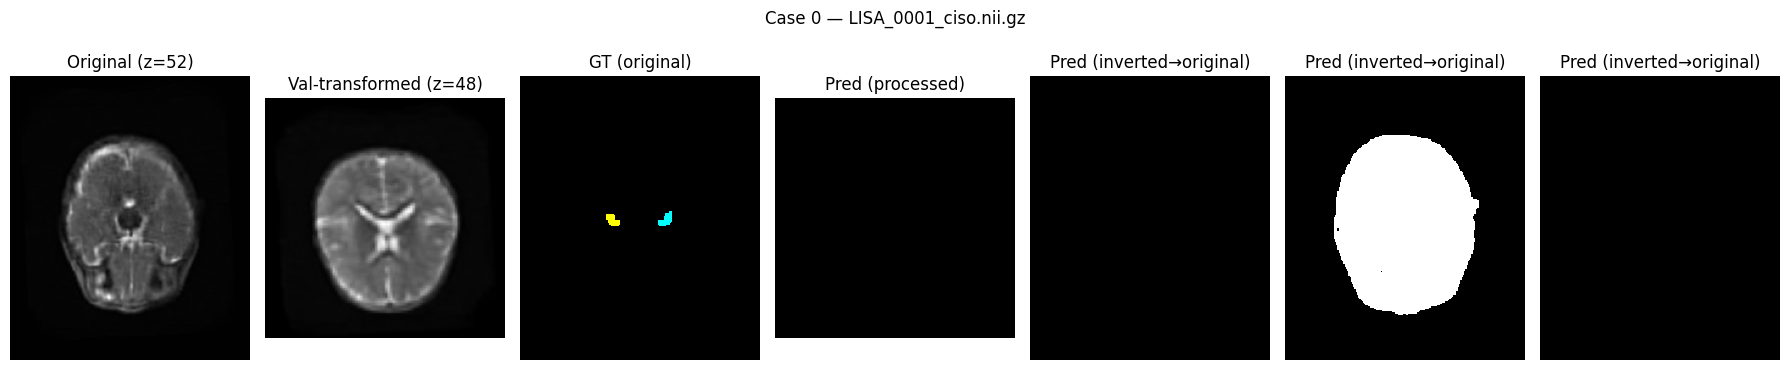

lbl_orig: 2 0 (189, 233, 197)


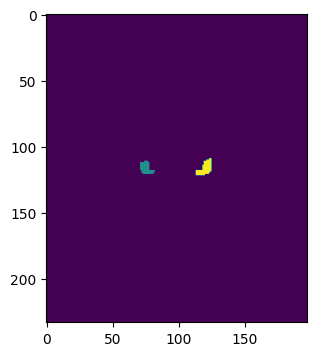

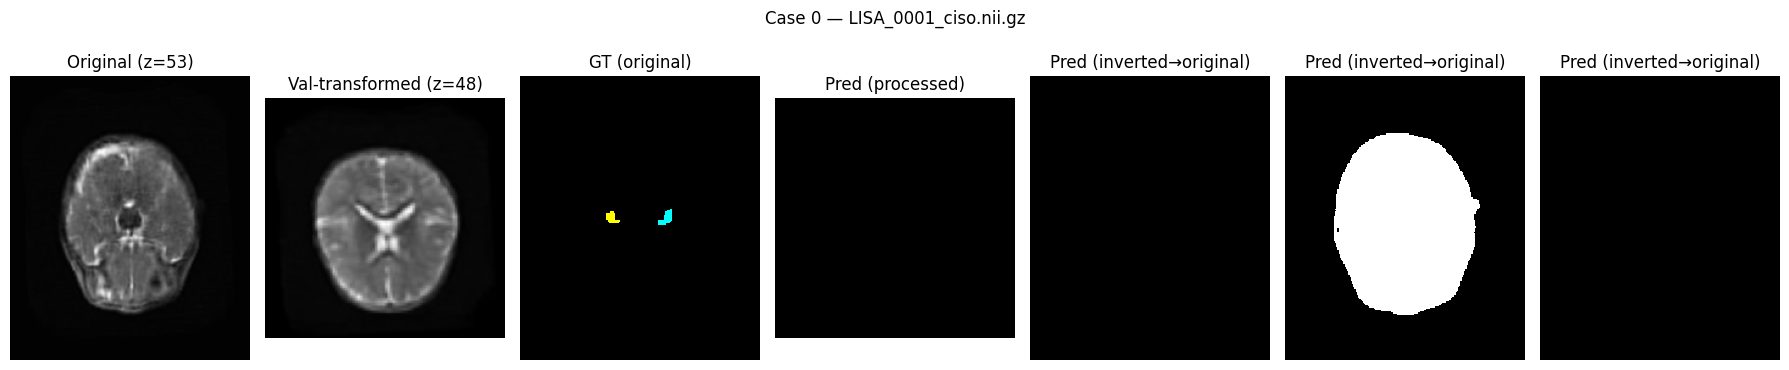

lbl_orig: 2 0 (189, 233, 197)


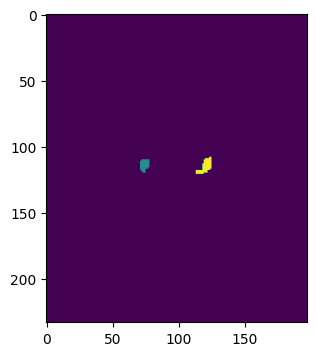

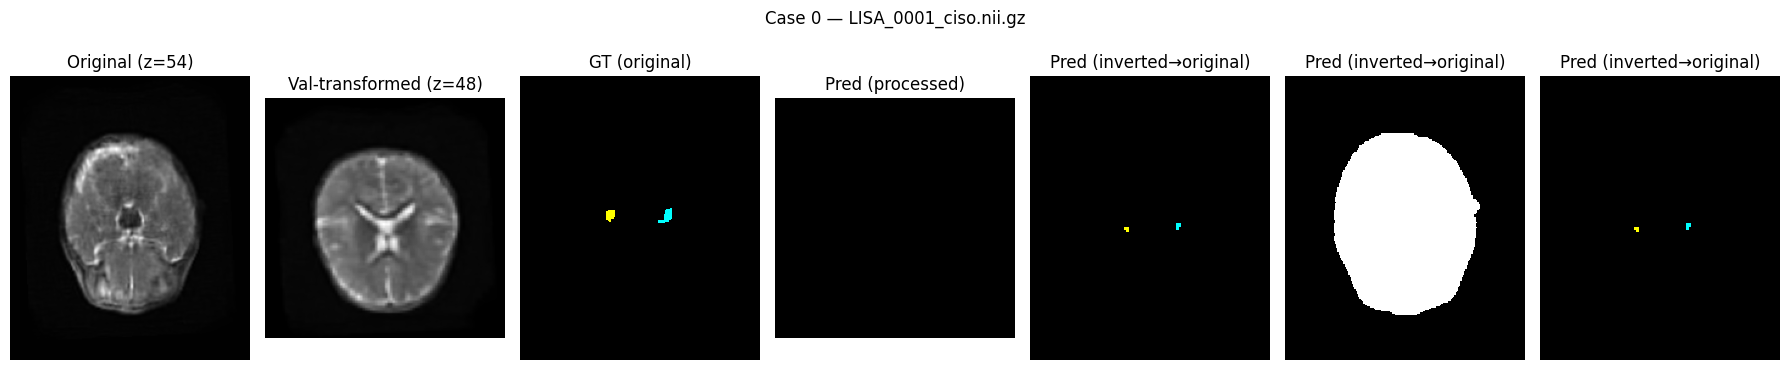

lbl_orig: 2 0 (189, 233, 197)


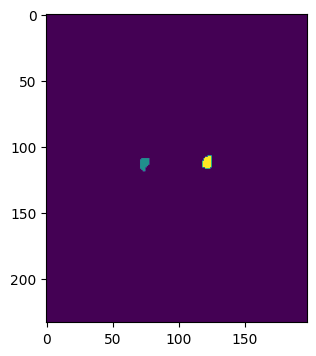

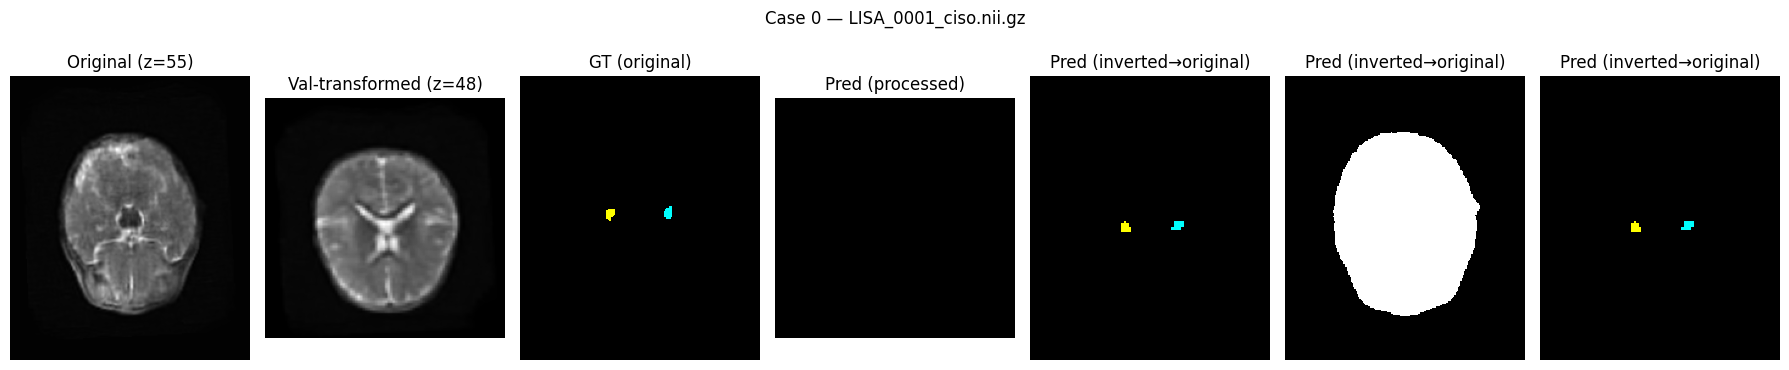

lbl_orig: 2 0 (189, 233, 197)


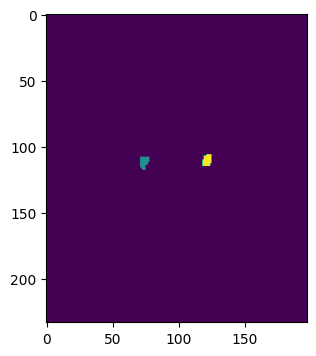

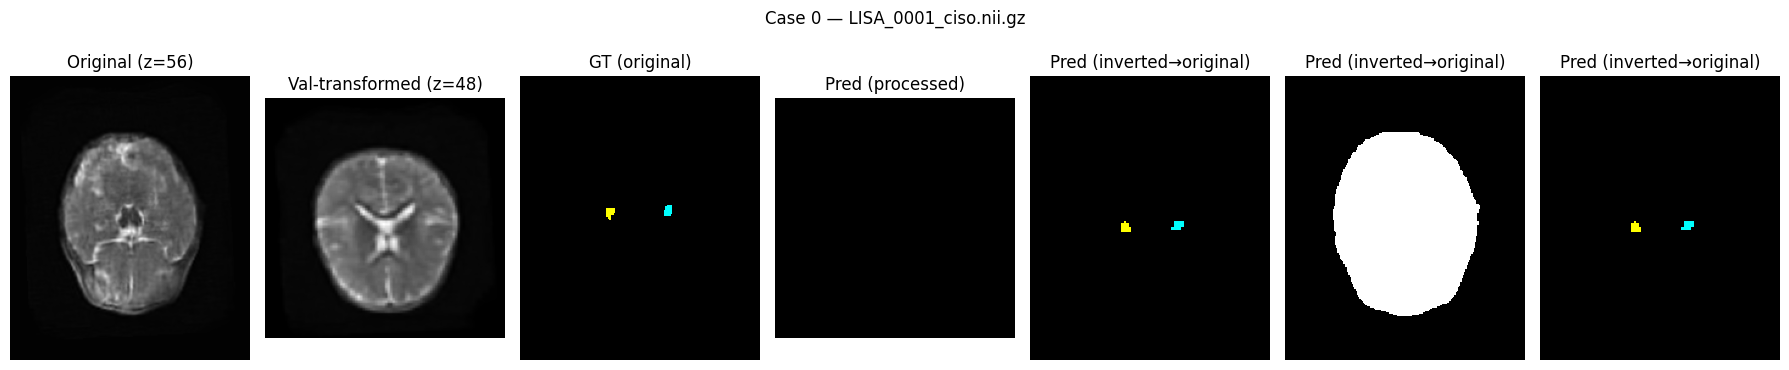

Train/Augmented image shape: (1, 96, 96, 96)
z_aug: 48


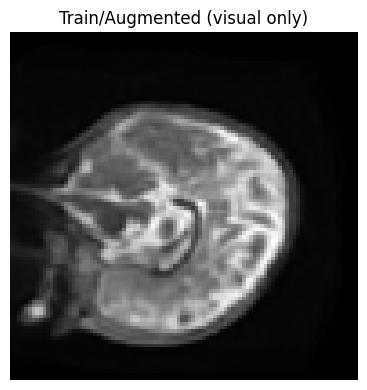

In [53]:
# =========================
# MONAI 3D Multiclase (0/1/2)
# Sliding-Window + Invertd
# =========================
import os, copy
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRanged, EnsureTyped, CropForegroundd, Resized,
    Activationsd, AsDiscreted, Invertd
)
from monai.utils import set_determinism
from matplotlib.colors import ListedColormap

# -----------------------
# Constantes
# -----------------------
SPACING      = (1.0, 1.0, 1.0)
SPATIAL_SIZE = (96,96,96)#120, 120, 120)   # tamaño destino en validación/entrenamiento
ROI_SIZE     = SPATIAL_SIZE      # para SWI (puedes aumentarlo si tus volúmenes procesados son mayores)
OVERLAP      = 0.25
SW_BATCH     = 1

# -----------------------
# Dataset (estilo MONAI)
# -----------------------
import pandas as pd
# -----------------------
# Utilidades
# -----------------------
def load_nifti(path):
    nii = nib.load(path)
    arr = nii.get_fdata()
    return np.asarray(arr, dtype=np.float32)

CLS_CMAP = ListedColormap([[0,0,0], [1,1,0], [0,1,1]])  # 0=negro, 1=amarillo, 2=cian

def _rm_channel(x):
    if x is None: return None
    x = np.asarray(x)
    if x.ndim == 4 and x.shape[0] == 1:
        x = x[0]
    x = np.swapaxes(x, 0, 2)  # (W,H,D)
    return x

def choose_slice_z(l=None, img=None):
    if l is not None:
        if l is not None and l.ndim == 3 and np.max(l) > 0:
            D = l.shape[0]
            areas = [np.count_nonzero(l[z] > 0) for z in range(D)]
            idx  = int(np.argmax(areas))
            print("MAX area id :",idx, "area:",areas[idx])
            return int(np.argmax(areas))
    i = _rm_channel(img)
    return (i.shape[0] // 2) if (i is not None) else 0

def show_grid5_multiclass(img_orig, img_val, lbl_orig, pred_proc, pred_inv, img_orig_masked,pred_inv_masked,z_idx=None, suptitle=""):
    img_orig = _rm_channel(img_orig)
    img_val  = _rm_channel(img_val)
    lbl_orig = _rm_channel(lbl_orig)
    pred_proc= _rm_channel(pred_proc)
    pred_inv = _rm_channel(pred_inv)
    img_orig_masked = _rm_channel(img_orig_masked)
    pred_inv_masked = _rm_channel(pred_inv_masked)

    if z_idx is None: z_idx = choose_slice_z(lbl_orig, img_orig)
    for z_idx in range(z_idx-5,z_idx+5):
      z2 = img_val.shape[0]//2 if img_val is not None else z_idx
      z3 = pred_proc.shape[0]//2 if pred_proc is not None else z_idx

      print("lbl_orig:",lbl_orig.max(),lbl_orig.min(),lbl_orig.shape)
      fig = plt.figure(figsize=(4, 4))
      plt.imshow(lbl_orig[z_idx])
      plt.show()
      fig, axs = plt.subplots(1, 7, figsize=(18,4))
      for ax in axs: ax.axis("off")

      axs[0].imshow(img_orig[z_idx], cmap="gray");                               axs[0].set_title(f"Original (z={z_idx})")
      axs[1].imshow(img_val[z2],   cmap="gray");                                 axs[1].set_title(f"Val-transformed (z={z2})")
      axs[2].imshow(lbl_orig[z_idx], cmap=CLS_CMAP, vmin=0, vmax=2, interpolation="nearest") if lbl_orig is not None else axs[2].imshow(np.zeros_like(img_orig[z_idx]))
      axs[2].set_title("GT (original)")

      axs[3].imshow(pred_proc[z3], cmap=CLS_CMAP, vmin=0, vmax=2, interpolation="nearest") if pred_proc is not None else axs[3].imshow(np.zeros_like(img_orig[z_idx]))
      axs[3].set_title("Pred (processed)")

      axs[4].imshow(pred_inv[z_idx], cmap=CLS_CMAP, vmin=0, vmax=2, interpolation="nearest") if pred_inv is not None else axs[4].imshow(np.zeros_like(img_orig[z_idx]))
      axs[4].set_title("Pred (inverted→original)")

      axs[5].imshow(img_orig_masked[z_idx], cmap="gray", interpolation="nearest") if img_orig_masked is not None else axs[4].imshow(np.zeros_like(img_orig[z_idx]))
      axs[5].set_title("Pred (inverted→original)")

      axs[6].imshow(pred_inv_masked[z_idx], cmap=CLS_CMAP, vmin=0, vmax=2, interpolation="nearest") if pred_inv_masked is not None else axs[4].imshow(np.zeros_like(img_orig[z_idx]))
      axs[6].set_title("Pred (inverted→original)")

      plt.suptitle(suptitle); plt.tight_layout(); plt.show()

# -----------------------
# DataFrame de entrada
# -----------------------
# Opción A: ya tienes df_train
# df_train = <tu DataFrame con 'filepath' y 'filepath_label'>

# Opción B: cargar desde CSV (ajusta ruta si quieres esta opción)
# CSV_PATH = "../results/preprocessed_data/task2/df_train_hipp.csv"
# df_train = pd.read_csv(CSV_PATH)

assert "filepath" in df_train.columns, "df_train debe incluir la columna 'filepath'"
assert "filepath_label" in df_train.columns, "df_train debe incluir 'filepath_label'"

# -----------------------
# Datasets / Loaders
# -----------------------
val_tfm   = get_val_transforms()
train_tfm = get_train_transforms(augment=True)  # sólo para visualizar cómo se ve con aug

ds_val   = MRIDataset3D(df_train, is_train=True, transform=val_tfm)
ds_train = MRIDataset3D(df_train, is_train=True, transform=val_tfm)

val_loader = DataLoader(ds_val, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# -----------------------
# Modelo (multiclase 0/1/2)
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,                 # 3 clases
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
).to(device).eval()


N_CLASSES = 3
DEVICE  = "cuda:0"

# Si tienes tu UNeST custom:
import sys
sys.path.append("../")
try:
    from src.models import get_model  # tu UNeST
except Exception:
    get_model = None


def create_model(model_name="unest"):
    if model_name.lower() == "unet":
        from monai.networks.nets import UNet
        return UNet(
            spatial_dims=3, in_channels=1, out_channels=N_CLASSES,
            channels=(16,32,64,128), strides=(2,2,2)
        ).to(DEVICE).eval()
    elif model_name.lower() == "unest":
        return get_model(name="unest", num_classes=N_CLASSES, device=str(DEVICE)).eval()
    else:
        raise ValueError("Modelo no soportado")


model = create_model("unest")
ckpt  = os.path.join("./fold_models/fold_2", "best_model.pth")
print("reading checkpoint:", ckpt)
model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
model.eval()


# -----------------------
# Post-procesado (softmax + argmax)
# -----------------------
post_pred = Compose([
    Activationsd(keys="pred", softmax=True),
    AsDiscreted(keys="pred", argmax=True),
])

# -----------------------
# Inferencia + Invertd
# -----------------------
MAX_CASES = 1   # cambia si quieres varios casos

with torch.no_grad():
    for idx_case, batch in enumerate(val_loader):
        if idx_case >= MAX_CASES: break

        img_path = batch["image_path"][0]
        lbl_path = batch.get("label_path", [""])[0]
        print(f"\n=== Case {idx_case} ===")
        print("image_path:", img_path)
        print("label_path:", lbl_path)

        # ---- Original (sin transforms) ----
        img_orig = load_nifti(img_path)                                 # (Z,H,W) en Nifti (orden puede variar); nib lo entrega como (X,Y,Z) -> MONAI ordena a RAS en pipeline
        lbl_orig = load_nifti(lbl_path).astype(np.int16) if (lbl_path and os.path.exists(lbl_path)) else None
        print("Original image shape:", img_orig.shape)
        if lbl_orig is not None: print("Original label shape:", lbl_orig.shape)

        # ---- Procesado (val_tfm) ----
        img_val_t = batch["image"]                      # MetaTensor (B, C, D, H, W)
        lbl_val_t = batch.get("label", None)
        print("Processed image tensor:", tuple(img_val_t.shape))
        if lbl_val_t is not None: print("Processed label tensor:", tuple(lbl_val_t.shape))

        # ---- Sliding-window inference ----
        image = img_val_t.to(device)
        logits = sliding_window_inference(
            inputs=image,
            roi_size=ROI_SIZE,
            sw_batch_size=SW_BATCH,
            predictor=model,
            overlap=OVERLAP,
            mode="gaussian",
        )                                               # (B, C=3, D, H, W)
        batch["pred"] = logits.cpu()

        # ---- Decouple + post + Invertd ----
        elems = decollate_batch(batch)
        preds_proc = []
        preds_inv  = []

        for elem in elems:
            # softmax+argmax -> mapa de etiquetas (D,H,W)
            elem = post_pred(elem)
            pred_proc_np = elem["pred"].cpu().numpy()   # (D,H,W)
            preds_proc.append(pred_proc_np)

            # preparar metadatos para inversión
            elem["pred_meta_dict"] = copy.deepcopy(elem["image"].meta)

            inv = Invertd(
                keys="pred",
                transform=val_tfm,
                orig_keys="image",
                meta_keys="pred_meta_dict",
                orig_meta_keys="image_meta_dict",
                nearest_interp=True,  # etiquetas -> vecino
                to_tensor=True,
            )
            elem = inv(elem)
            pred_inv_np = elem["pred"].cpu().numpy()    # (D,H,W)
            preds_inv.append(pred_inv_np)

        print("Pred (processed) shape:", preds_proc[0].shape)
        print("Pred (inverted to original) shape:", preds_inv[0].shape)

        # ---- Visual extra: mismo caso con train/augment ----
        sample_train_aug = ds_train[idx_case]
        img_train_aug = sample_train_aug["image"].as_tensor().cpu().numpy()  # (1,1,D,H,W)

        # ---- Plots (5 columnas) ----
        show_grid5_multiclass(
            img_orig=img_orig,                 # 1) original
            img_val=img_val_t[0,0].cpu().numpy(),  # 2) val-transformed
            lbl_orig=lbl_orig,                 # 3) GT original
            pred_proc=preds_proc[0],           # 4) pred en procesado
            pred_inv=preds_inv[0],             # 5) pred invertida al original
            img_orig_masked=(img_orig>0.5)*1,             # 5) pred invertida al original
            pred_inv_masked=(img_orig>0.5)*preds_inv[0],             # 5) pred invertida al original
            suptitle=f"Case {idx_case} — {os.path.basename(img_path)}"
        )

        # ---- Mostrar la imagen con augment (opcional) ----
        z_aug = img_train_aug.shape[-3] // 2
        print("Train/Augmented image shape:", img_train_aug.shape)
        print("z_aug:", z_aug )
        plt.figure(figsize=(4,4))
        plt.imshow(img_train_aug[0,z_aug], cmap="gray")
        plt.title("Train/Augmented (visual only)")
        plt.axis("off"); plt.tight_layout(); plt.show()


In [54]:
img_orig.max()

16.108599